In [1]:
# Learning Optimal Tic-Tac-Toe Moves via a Neural Network
#---------------------------------------
#
# We will build a one-hidden layer neural network
#  to predict the optimal response given a set
#  of tic-tac-toe boards.
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import random
import numpy as np
import random
from tensorflow.python.framework import ops
ops.reset_default_graph()

In [2]:
# X = 1
# O = -1
# empty = 0
# response on 1-9 grid for placement of next '1'


# For example, the 'test_board' is:
#
#   O  |  -  |  -
# -----------------
#   X  |  O  |  O
# -----------------
#   -  |  -  |  X
#
# board above = [-1, 0, 0, 1, -1, -1, 0, 0, 1]
# Optimal response would be position 6, where
# the position numbers are:
#
#   0  |  1  |  2
# -----------------
#   3  |  4  |  5
# -----------------
#   6  |  7  |  8

In [3]:
response = 6
batch_size = 50
symmetry = ['rotate180', 'rotate90', 'rotate270', 'flip_v', 'flip_h']

In [4]:
# Print a board
def print_board(board):
    symbols = ['O',' ','X']
    board_plus1 = [int(x) + 1 for x in board]
    print(' ' + symbols[board_plus1[0]] + ' | ' + symbols[board_plus1[1]] + ' | ' + symbols[board_plus1[2]])
    print('___________')
    print(' ' + symbols[board_plus1[3]] + ' | ' + symbols[board_plus1[4]] + ' | ' + symbols[board_plus1[5]])
    print('___________')
    print(' ' + symbols[board_plus1[6]] + ' | ' + symbols[board_plus1[7]] + ' | ' + symbols[board_plus1[8]])

In [5]:
## Given a board, a response, and a transformation, get the new board+response
def get_symmetry(board, response, transformation):
    '''
    :param board: list of integers 9 long:
     opposing mark = -1
     friendly mark = 1
     empty space = 0
    :param transformation: one of five transformations on a board:
     'rotate180', 'rotate90', 'rotate270', 'flip_v', 'flip_h'
    :return: tuple: (new_board, new_response)
    '''
    if transformation == 'rotate180':
        new_response = 8 - response
        return(board[::-1], new_response)
    elif transformation == 'rotate90':
        new_response = [6, 3, 0, 7, 4, 1, 8, 5, 2].index(response)
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))
        return([value for item in tuple_board for value in item], new_response)
    elif transformation == 'rotate270':
        new_response = [2, 5, 8, 1, 4, 7, 0, 3, 6].index(response)
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]
        return([value for item in tuple_board for value in item], new_response)
    elif transformation == 'flip_v':
        new_response = [6, 7, 8, 3, 4, 5, 0, 1, 2].index(response)
        return(board[6:9] +  board[3:6] + board[0:3], new_response)
    elif transformation == 'flip_h':  # flip_h = rotate180, then flip_v
        new_response = [2, 1, 0, 5, 4, 3, 8, 7, 6].index(response)
        new_board = board[::-1]
        return(new_board[6:9] +  new_board[3:6] + new_board[0:3], new_response)
    else:
        raise ValueError('Method not implemented.')

In [6]:
## Read in board move csv file
def get_moves_from_csv(csv_file):
    '''
    :param csv_file: csv file location containing the boards w/ responses
    :return: moves: list of moves with index of best response
    '''
    moves = []
    with open(csv_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            moves.append(([int(x) for x in row[0:9]],int(row[9])))
    return(moves)

In [7]:
## Get random board with optimal move
def get_rand_move(moves, n=1, rand_transforms=2):
    '''
    :param moves: list of the boards w/responses
    :param n: how many board positions with responses to return in a list form
    :param rand_transforms: how many random transforms performed on each
    :return: (board, response), board is a list of 9 integers, response is 1 int
    '''
    (board, response) = random.choice(moves)
    possible_transforms = ['rotate90', 'rotate180', 'rotate270', 'flip_v', 'flip_h']
    for i in range(rand_transforms):
        random_transform = random.choice(possible_transforms)
        (board, response) = get_symmetry(board, response, random_transform)
    return(board, response)

In [8]:
# Get list of optimal moves w/ responses
moves = get_moves_from_csv('base_tic_tac_toe_moves.csv')

In [12]:
# Create a train set:
train_length = 500
train_set = []
for t in range(train_length):
    train_set.append(get_rand_move(moves))

In [13]:
# To see if the network learns anything new, we will remove
# all instances of the board [-1, 0, 0, 1, -1, -1, 0, 0, 1],
# which the optimal response will be the index '6'.  We will
# Test this at the end.
test_board = [-1, 0, 0, 1, -1, -1, 0, 0, 1]
train_set = [x for x in train_set if x[0] != test_board]

In [20]:
def init_weights(shape):
    return(tf.Variable(tf.random_normal(shape)))


def model(X, A1, A2, bias1, bias2):
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X, A1), bias1))
    layer2 = tf.add(tf.matmul(layer1, A2), bias2)
    return(layer2) # note that we dont take the softmax at the end because our cost fn does that for us

In [21]:
X = tf.placeholder(dtype=tf.float32, shape=[None, 9])
Y = tf.placeholder(dtype=tf.int32, shape=[None])

A1 = init_weights([9, 81])
bias1 = init_weights([81])
A2 = init_weights([81, 9])
bias2 = init_weights([9])

model_output = model(X, A1, A2, bias1, bias2)

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_output, labels=Y))
train_step = tf.train.GradientDescentOptimizer(0.025).minimize(loss)
prediction = tf.argmax(model_output, 1)

In [22]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [25]:
loss_vec = []
for i in range(10000):
    rand_indices = np.random.choice(range(len(train_set)), batch_size, replace=False)
    batch_data = [train_set[i] for i in rand_indices]
    x_input = [x[0] for x in batch_data]
    y_target = np.array([y[1] for y in batch_data])
    sess.run(train_step, feed_dict={X: x_input, Y: y_target})
    
    temp_loss = sess.run(loss, feed_dict={X: x_input, Y: y_target})
    loss_vec.append(temp_loss)
    if i%500==0:
        print('iteration ' + str(i) + ' Loss: ' + str(temp_loss))

iteration 0 Loss: 7.54332
iteration 500 Loss: 2.09006
iteration 1000 Loss: 1.82807
iteration 1500 Loss: 1.47941
iteration 2000 Loss: 1.66241
iteration 2500 Loss: 1.35398
iteration 3000 Loss: 1.19368
iteration 3500 Loss: 0.885685
iteration 4000 Loss: 1.01093
iteration 4500 Loss: 1.0826
iteration 5000 Loss: 1.32612
iteration 5500 Loss: 1.15273
iteration 6000 Loss: 0.935025
iteration 6500 Loss: 0.830843
iteration 7000 Loss: 1.00638
iteration 7500 Loss: 0.767846
iteration 8000 Loss: 0.727025
iteration 8500 Loss: 0.661663
iteration 9000 Loss: 0.765477
iteration 9500 Loss: 0.829696


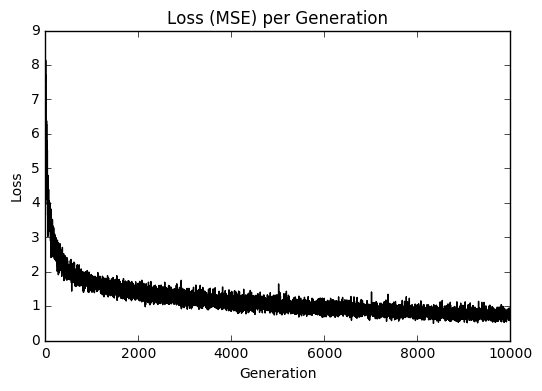

In [26]:
# Print loss
plt.plot(loss_vec, 'k-', label='Loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

In [27]:
# Make Prediction:
test_boards = [test_board]
feed_dict = {X: test_boards}
logits = sess.run(model_output, feed_dict=feed_dict)
predictions = sess.run(prediction, feed_dict=feed_dict)
print(predictions)

[2]


In [28]:
# Declare function to check for win
def check(board):
    wins = [[0,1,2], [3,4,5], [6,7,8], [0,3,6], [1,4,7], [2,5,8], [0,4,8], [2,4,6]]
    for i in range(len(wins)):
        if board[wins[i][0]]==board[wins[i][1]]==board[wins[i][2]]==1.:
            return(1)
        elif board[wins[i][0]]==board[wins[i][1]]==board[wins[i][2]]==-1.:
            return(1)
    return(0)

In [29]:
# Let's play against our model
game_tracker = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
win_logical = False
num_moves = 0
while not win_logical:
    player_index = input('Input index of your move (0-8): ')
    num_moves += 1
    # Add player move to game
    game_tracker[int(player_index)] = 1.
    
    # Get model's move by first getting all the logits for each index
    [potential_moves] = sess.run(model_output, feed_dict={X: [game_tracker]})
    # Now find allowed moves (where game tracker values = 0.0)
    allowed_moves = [ix for ix,x in enumerate(game_tracker) if x==0.0]
    # Find best move by taking argmax of logits if they are in allowed moves
    model_move = np.argmax([x if ix in allowed_moves else -999.0 for ix,x in enumerate(potential_moves)])
    
    # Add model move to game
    game_tracker[int(model_move)] = -1.
    print('Model has moved')
    print_board(game_tracker)
    # Now check for win or too many moves
    if check(game_tracker)==1 or num_moves>=5:
        print('Game Over!')
        win_logical = True

Input index of your move (0-8): 4
Model has moved
   |   |  
___________
   | X |  
___________
   |   | O
Input index of your move (0-8): 7
Model has moved
 O |   |  
___________
   | X |  
___________
   | X | O
Input index of your move (0-8): 2
Model has moved
 O |   | X
___________
   | X | O
___________
   | X | O
Input index of your move (0-8): 1
Model has moved
 O | X | X
___________
 O | X | O
___________
   | X | O
Game Over!
